In [3]:
import tensorflow as tf

tf.__version__

'1.13.1'

In [4]:
# Check available GPU devices
from tensorflow.python.client import device_lib

def get_available_gpus():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos if x.device_type == 'GPU']

# Print available GPUs
available_gpus = get_available_gpus()
if available_gpus:
    print("Available GPU(s):", available_gpus)
else:
    print("No GPUs found.")

Available GPU(s): ['/device:GPU:0']


## Imports

In [5]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as ss
import scipy.special as ssp
import sys
import scipy.io as sio
sys.path.append("../code/")
from pi_vae import *
from util import *
from keras.callbacks import ModelCheckpoint

from sklearn.model_selection import KFold

## import plot packages
from matplotlib.ticker import FormatStrFormatter
from matplotlib import ticker
import seaborn

%load_ext autoreload
%autoreload 2
%matplotlib inline

## Load Data

In [6]:
data_dir = "../data"
ecephys_session_id = 771160300
brain_region = 'VISp'

directory_path = os.path.join(data_dir, f'session_{ecephys_session_id}')

# Read spike count data pivoted by neurons and time bins
spike_data_file = f'{brain_region}_spike_count_{ecephys_session_id}_pivot_p4.csv'
spike_file_path = os.path.join(directory_path, spike_data_file)
if not os.path.exists(spike_file_path):
    raise FileNotFoundError(f"File {spike_file_path} does not exist")
spike_count_pivot = pd.read_csv(spike_file_path)

# Read behavior data
behavior_data_file = f'NaturalMovie_Behavior_{ecephys_session_id}_normalized_p4.csv'
behavior_file_path = os.path.join(directory_path, behavior_data_file)
if not os.path.exists(behavior_file_path):
    raise FileNotFoundError(f"File {behavior_file_path} does not exist")
behavior_data_df = pd.read_csv(behavior_file_path)


In [7]:
spike_count_pivot.shape

(54000, 82)

In [8]:
spike_count_pivot.shape

(54000, 82)

## Prepare Data

In [9]:
from data_processing import *

selected_behavior_vars = ['frame']

x_all, u_all = transform_data(spike_count_pivot, behavior_data_df, selected_behavior_vars)

### Downsample

In [10]:
def downsample(frames_per_window, x_all, u_all):
    # Check if frames_per_window is an odd number and divisor of the total frames
    total_frames = x_all[0].shape[0]
    if total_frames % frames_per_window != 0 or frames_per_window % 2 == 0:
        raise ValueError("Frames per window must be an odd number and a divisor of the total number of frames.")

    # Calculate the index of the middle frame in each window
    middle_index = frames_per_window // 2

    # Summing frames within each window and take the spike counts
    x_all_downsample = [np.sum(x_all[i].reshape(-1, frames_per_window, x_all[i].shape[-1]), axis=1) for i in range(len(x_all))]

    # Ensure the new shape is as expected
    print("New shape for each element:", x_all_downsample[0].shape)

    # Selecting the middle frame index from each window
    u_all_downsample = [u_all[i][middle_index::frames_per_window] for i in range(len(u_all))]

    # Ensure the new shape is as expected
    print("New shape for each element in u:", u_all_downsample[0].shape)

    return np.array(x_all_downsample), np.array(u_all_downsample)

In [13]:
frames_tick = 5
x_all_downsample, u_all_downsample = downsample(frames_tick, x_all, u_all)

New shape for each element: (180, 82)
New shape for each element in u: (180, 1)


In [14]:
x_all_downsample.shape

(60, 180, 82)

### Dry run

In [15]:
# Define model?
LATENT_DIM = 10
MODEL = "PiVAE"

np.random.seed(666);
vae = vae_mdl(dim_x=x_all[0].shape[-1], 
                   dim_z=LATENT_DIM,
                   dim_u=u_all[0].shape[-1], 
                   gen_nodes=60, n_blk=2, mdl='poisson', disc=False, learning_rate=5e-4)

Instructions for updating:
Colocations handled automatically by placer.
Model: "vae"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 82)           0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
encoder (Model)                 [(None, 10), (None,  19380       input_1[0][0]                    
                                                                 input_3[0][0]                    
__________________________________________________________________________________________________
decoder (Model)         

/ext3/miniconda3/envs/demo/lib/python3.6/site-packages/keras/engine/training_utils.py:819: UserWarning: Output encoder missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to encoder.
  'be expecting any data to be passed to {0}.'.format(name))
/ext3/miniconda3/envs/demo/lib/python3.6/site-packages/keras/engine/training_utils.py:819: UserWarning: Output decoder missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to decoder.
  'be expecting any data to be passed to {0}.'.format(name))


In [16]:
from sklearn.model_selection import KFold
kf = KFold(n_splits=10, shuffle=True, random_state=666)
fold = 0
train, test=[], []
for train_index, test_index in kf.split(x_all):
    train, test = train_index, test_index
    break

train, test

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 22, 24, 26, 27, 28, 29, 30, 31, 33, 35, 36, 37, 38, 39,
        40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56,
        57, 58, 59]),
 array([ 8, 21, 23, 25, 32, 34]))

In [17]:
# x_train, x_valid = x_all[train], x_all[test]
# u_train, u_valid = u_all[train], u_all[test]

x_train, x_valid = x_all_downsample[train], x_all_downsample[test]
u_train, u_valid = u_all_downsample[train], u_all_downsample[test]

In [18]:
model_chk_path = f'../results/F_{frames_tick}rsmpl_rat_{LATENT_DIM}d_666_{MODEL}_{selected_behavior_vars[0]}.h5' ##999, 777
mcp = ModelCheckpoint(model_chk_path, monitor="val_loss", save_best_only=True, save_weights_only=True)
# s_n = vae.fit_generator(custom_data_generator(x_train, u_train),
#               steps_per_epoch=len(x_train), epochs=300, 
#               verbose=1,
#               validation_data = custom_data_generator(x_valid, u_valid),
#               validation_steps = len(x_valid), callbacks=[mcp]);

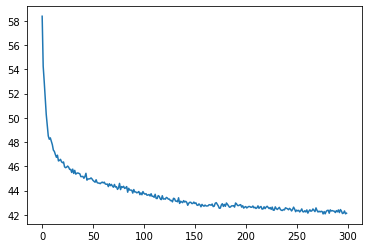

In [33]:
plt.plot(s_n.history['val_loss'][:])

In [19]:
# model_chk_path = '../results/F_rat_10d_666_VAE.h5'
model_chk_path = f'../results/F_{frames_tick}rsmpl_rat_{LATENT_DIM}d_666_{MODEL}_{selected_behavior_vars[0]}.h5' ##999, 777
vae.load_weights(model_chk_path);

In [20]:
outputs = vae.predict_generator(custom_data_generator(x_all, u_all),
                                                steps = len(x_all));
# post_mean, post_log_var, z_sample,fire_rate, lam_mean, lam_log_var, z_mean, z_log_var
print(outputs[0].var(axis=0))  ## variance of each latent dimension

InternalError: Blas GEMM launch failed : a.shape=(900, 82), b.shape=(82, 60), m=900, n=60, k=82
	 [[{{node encoder/dense_4/MatMul}}]]
	 [[{{node encoder/dense_6/BiasAdd}}]]

In [ ]:
z_pred_all = [];
for ii in range(len(x_all)):
    z_pred_all.append(vae.predict([x_all[ii], u_all[ii]])[0][:,:]);
z_pred_all = np.array(z_pred_all);

In [ ]:
variances = outputs[0].var(axis=0)
# Sort the columns by variance in descending order and get the indices
sorted_indices = np.argsort(variances)[::-1]

# Create a new object containing the columns of outputs[0] sorted by variance
sorted_outputs = outputs[0][:, sorted_indices]
print(variances,'\n')
print(sorted_outputs.var(axis=0),'\n',sorted_indices)

u_values = behavior_data_df['frame'].unique()

## Modeling

In [19]:
from keras.callbacks import ModelCheckpoint
from keras import backend as K
from sklearn.model_selection import KFold

def build_vae(dim_x, dim_u, latent_dim=10, gen_nodes=60, n_blk=2, mdl='poisson', disc=False, learning_rate=5e-4):
    # Assuming vae_mdl is a function that returns a compiled VAE model
    return vae_mdl(dim_x=dim_x, dim_z=latent_dim, dim_u=dim_u, gen_nodes=gen_nodes, n_blk=n_blk, mdl=mdl, disc=disc, learning_rate=learning_rate)

def train_and_save_model(x_train, u_train, x_valid, u_valid, latent_dim, epochs, fold_number, random_seed):
    # Build the VAE model
    vae = build_vae(dim_x=x_train[0].shape[-1], dim_u=u_train[0].shape[-1], latent_dim=latent_dim)
    
    # Define the directory path for model checkpointing
    # directory = f'../results/rat_{latent_dim}d_{random_seed}_NP_5_frames'
    directory = f'../results/rat_{latent_dim}d_{random_seed}_NP_5_{brain_region}_{selected_behavior_vars[0]}'
    if not os.path.exists(directory):
        os.makedirs(directory)
    model_chk_path = f'{directory}/model_fold_{fold_number}.h5'
    
    # Setup model checkpointing
    mcp = ModelCheckpoint(model_chk_path, monitor="val_loss", save_best_only=True, save_weights_only=True)
    
    # Fit the model using fit_generator
    s_n = vae.fit_generator(custom_data_generator(x_train, u_train),
                            steps_per_epoch=len(x_train), epochs=epochs, 
                            verbose=1,
                            validation_data=custom_data_generator(x_valid, u_valid),
                            validation_steps=len(x_valid), callbacks=[mcp])
    
    # Clear the session to free up memory and prevent slowdowns
    K.clear_session()

def perform_k_fold_cv(x_all, u_all, latent_dim, epochs, random_seed, n_splits=5):
    np.random.seed(random_seed);
    
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=random_seed)
    fold = 0
    kfold_indices = kf.split(x_all) # save and return for tuning curve use
    
    for train_index, test_index in kfold_indices:
        x_train, x_valid = x_all[train_index], x_all[test_index]
        u_train, u_valid = u_all[train_index], u_all[test_index]
        
        train_and_save_model(x_train, u_train, x_valid, u_valid, latent_dim, epochs, fold, random_seed)
        fold += 1

    return kfold_indices

### Initialize and Fit models

In [46]:
RANDOM_SEED = 666
n_folds = 10

kfold_indices = perform_k_fold_cv(x_all=x_all_downsample, u_all=u_all_downsample, latent_dim=10, epochs=100, random_seed=RANDOM_SEED, n_splits=n_folds)

Model: "vae"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            (None, 249)          0                                            
__________________________________________________________________________________________________
input_9 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
encoder (Model)                 [(None, 10), (None,  39420       input_7[0][0]                    
                                                                 input_9[0][0]                    
__________________________________________________________________________________________________
decoder (Model)                 (None, 249)          129017      encoder[1][2]                  

In [29]:
kf = KFold(n_splits=10, shuffle=True, random_state=666)
kfold_indices = kf.split(x_all_downsample)

In [12]:
# plt.plot(s_n.history['val_loss'][:])

## Decoding

### Prepare random samples

In [21]:
def generate_u_fake(x_test, frame_bins, nu_samples):
    """
    Generate a synthetic u dataset (u_fake_np) based on provided frame bins and test data.

    Parameters:
    - x_test: array-like, the test dataset where each element corresponds to a session.
    - frame_bins: array-like, unique frame indices to be used for generating u_fake.
    - nu_samples: int, number of unique frame indices to sample.

    Returns:
    - np.array, synthetic u dataset (u_fake_np).
    """
    np.random.seed(666)  # Seed for reproducibility
    u_fake_np = []
    
    # Ensure that the number of samples does not exceed the length of frame_bins
    nu_samples = min(nu_samples, len(frame_bins))
    
    for jj in range(nu_samples):
        tmp_all_np = []
        for ii in range(len(x_test)):
            nn = x_test[ii].shape[0]
            # Fill with the current frame bin value for all samples in this part of the dataset
            tmp_np = np.full((nn, 1), frame_bins[jj])
            tmp_all_np.append(tmp_np)
        u_fake_np.append(np.array(tmp_all_np))
    
    return np.array(u_fake_np)

### Decode and compute metric

In [27]:
# from tqdm import tqdm
# import scipy.special as ssp
# from data_processing import *

# def build_vae(dim_x, dim_u, latent_dim=10, gen_nodes=60, n_blk=2, mdl='poisson', disc=False, learning_rate=5e-4):
#     # Assuming vae_mdl is a function that returns a compiled VAE model
#     return vae_mdl(dim_x=dim_x, dim_z=latent_dim, dim_u=dim_u, gen_nodes=gen_nodes, n_blk=n_blk, mdl=mdl, disc=disc, learning_rate=learning_rate)

# def load_and_decode_vae(model, x_test, u_fake_np, model_path, n_sample=50, nu_samples=180):
#     model.load_weights(model_path)
#     pbar = tqdm(total=len(x_test) * len(u_fake_np), desc="Computing likelihoods for VAE")
#     lik_all_np = []
#     for jj in range(len(x_test)):
#         # print(f"test {jj}")
#         y_test_batch = x_test[jj]
#         lik_batch = compute_marginal_lik_single_batch(model, y_test_batch, u_fake_np, n_sample, pbar)
#         lik_all_np.append(lik_batch)
#     pbar.close()
#     decode_use_np = np.array([(lik.reshape(nu_samples, -1, order="F").argmax(axis=0)) for lik in lik_all_np])
#     return decode_use_np

# def load_and_decode_tc(x_train, x_test, frame_bins):
#     tc = np.array(x_train).mean(axis=0) 
#     lik_tc = [np.array([np.exp((x_test[jj]*np.log(np.clip(tc[ii],1e-7,1e6)) - tc[ii]).sum(axis=-1)) for ii in range(tc.shape[0])]) for jj in range(len(x_test))];
#     lik_tc_use = np.concatenate([np.log(lik_tc[jj].mean(axis=0)) - ssp.loggamma(x_test[jj]+1).sum(axis=-1) for jj in range(len(lik_tc))]);
    
#     decode_tc_use = np.array([lik_tc[jj].argmax(axis=0) for jj in range(len(lik_tc))]);
#     # decode_tc_use_final = np.array([frame_bins[decode_tc_use[jj]] for jj in range(len(x_test))])
#     return decode_tc_use
    
# def compute_error(decoded_indices, u_test, frame_bins):
#     errors = [np.abs(frame_bins[decoded] - u[:, 0]) for decoded, u in zip(decoded_indices, u_test)]
#     return np.median(np.concatenate(errors))

# def run_decoding_for_fold(model, x_train, u_train, x_test, u_test, u_fake, model_path, frame_bins, fold_number, error_file_path, n_sample=50, bin_len=181):
#     # Decoding
#     # print("start to move")
#     decoded_indices_pivae = load_and_decode_vae(model, x_test, u_fake, model_path, n_sample)
#     # print("moving")
#     decoded_indices_tc = load_and_decode_tc(x_train, x_test, frame_bins)

#     # Median Error
#     error_pivae = compute_error(decoded_indices_pivae, u_test, frame_bins)
#     error_tc = compute_error(decoded_indices_tc, u_test, frame_bins)

#     # Append errors to the unified error file
#     # with open(error_file_path, 'a') as file:
#     #     file.write(f"{fold_number}, {error_pivae:.3f}, {error_tc:.3f}\n")
#     print(f"fold {fold_number}, Pi_vae error: {error_pivae:.3f}, TC error: {error_tc:.3f}\n")
#     print(f"Appended errors for fold {fold_number} to {error_file_path}")
from tqdm import tqdm
import scipy.special as ssp
from data_processing import *

def load_and_decode_vae(model, x_test, u_fake_np, model_path, n_sample=50, nu_samples=180):
    model.load_weights(model_path)
    pbar = tqdm(total=len(x_test) * len(u_fake_np), desc="Computing likelihoods for VAE")
    lik_all_np = []
    for jj in range(len(x_test)):
        # print(f"test {jj}")
        y_test_batch = x_test[jj]
        lik_batch = compute_marginal_lik_single_batch(model, y_test_batch, u_fake_np, n_sample, pbar)
        lik_all_np.append(lik_batch)
    pbar.close()
    decode_use_np = np.array([(lik.reshape(nu_samples, -1, order="F").argmax(axis=0)) for lik in lik_all_np])
    return decode_use_np

def load_and_decode_tc(x_train, x_test, frame_bins):
    tc = np.array(x_train).mean(axis=0) 
    lik_tc = [np.array([np.exp((x_test[jj]*np.log(np.clip(tc[ii],1e-7,1e6)) - tc[ii]).sum(axis=-1)) for ii in range(tc.shape[0])]) for jj in range(len(x_test))];
    lik_tc_use = np.concatenate([np.log(lik_tc[jj].mean(axis=0)) - ssp.loggamma(x_test[jj]+1).sum(axis=-1) for jj in range(len(lik_tc))]);
    
    decode_tc_use = np.array([lik_tc[jj].argmax(axis=0) for jj in range(len(lik_tc))]);
    # decode_tc_use_final = np.array([frame_bins[decode_tc_use[jj]] for jj in range(len(x_test))])
    return decode_tc_use
    
def compute_error(decoded_indices, u_test, frame_bins):
    errors = [np.abs(frame_bins[decoded] - u[:, 0]) for decoded, u in zip(decoded_indices, u_test)]
    err_concat = np.concatenate(errors)
    return np.median(err_concat), err_concat

def run_decoding_for_fold(model, x_train, u_train, x_test, u_test, u_fake, model_path, frame_bins, fold_number, error_file_path, n_sample=50, bin_len=181):
    # Decoding
    # print("start to move")
    decoded_indices_pivae = load_and_decode_vae(model, x_test, u_fake, model_path, n_sample)
    # print("moving")
    decoded_indices_tc = load_and_decode_tc(x_train, x_test, frame_bins)

    # Median Error
    error_pivae, error_pivae_concat = compute_error(decoded_indices_pivae, u_test, frame_bins)
    error_tc, error_tc_concat = compute_error(decoded_indices_tc, u_test, frame_bins)

    # Append errors to the unified error file
    with open(error_file_path, 'a') as file:
        file.write(f"{fold_number}, {error_pivae:.3f}, {error_tc:.3f}\n")
    print(f"fold {fold_number}, Pi_vae error: {error_pivae:.3f}, TC error: {error_tc:.3f}\n")
    print(f"Appended errors for fold {fold_number} to {error_file_path}")

    return error_pivae_concat, error_tc_concat
    

In [36]:
# mdl_path =  f'../results/F_{frames_tick}rsmpl_rat_{LATENT_DIM}d_666_{MODEL}_{selected_behavior_vars[0]}.h5'
# def main(x_all, u_all, kfold_indices, latent_dim, random_seed):
#     directory = f'../results/rat_{latent_dim}d_{random_seed}_NP_5_{brain_region}_{selected_behavior_vars[0]}'
#     frame_bins = np.unique(u_all)
#     # error_file_path = os.path.join(directory, 'model_errors_F.txt')

#     # # Ensure the directory exists and initialize the error file
#     # if not os.path.exists(directory):
#     #     os.makedirs(directory)
#     # with open(error_file_path, 'w') as file:
#     #     file.write("Fold, Pi-VAE Error, TC Error\n")

#     model = build_vae(dim_x=x_all[0].shape[-1], dim_u=u_all[0].shape[-1], latent_dim=latent_dim)
#     # Process each fold
#     for fold_number, (train_index, test_index) in enumerate(kfold_indices):
#         # if fold_number < 8:
#         #     continue
#         print(fold_number)
#         x_train, x_test = x_all[train_index], x_all[test_index]
#         u_train, u_test = u_all[train_index], u_all[test_index]
#         # x_test = x_test[:1] 
#         # u_test = u_test[:1]

#         # Generate u_fake
#         nu_samples = 180  # Define the number of unique frame indices to sample
#         u_fake = generate_u_fake(x_test, frame_bins=frame_bins, nu_samples=nu_samples)

#         # Decode and compute error for Pi-VAE & Tuning Curve
#         # model_path = os.path.join(directory, f'model_fold_{fold_number}.h5')
#         run_decoding_for_fold(model, x_train, u_train, x_test, u_test, u_fake, mdl_path, frame_bins, fold_number, None)

def main(x_all, u_all, kfold_indices, latent_dim, random_seed):
    # directory = f'../results/rat_{latent_dim}d_{random_seed}_NP_5_{brain_region}_{selected_behavior_vars[0]}'
    directory = f'../results/rat_{latent_dim}d_{random_seed}_NP_5_frames'
    frame_bins = np.unique(u_all)
    # error_file_path = os.path.join(directory, 'model_errors.txt')

    # # Ensure the directory exists and initialize the error file
    # if not os.path.exists(directory):
    #     os.makedirs(directory)
    # with open(error_file_path, 'w') as file:
    #     file.write("Fold, Pi-VAE Error, TC Error\n")

    model = build_vae(dim_x=x_all[0].shape[-1], dim_u=u_all[0].shape[-1], latent_dim=latent_dim)
    fold_error_lists = []
    # Process each fold
    for fold_number, (train_index, test_index) in enumerate(kfold_indices):
        if fold_number > 2:
            break
        print(fold_number)
        x_train, x_test = x_all[train_index], x_all[test_index]
        u_train, u_test = u_all[train_index], u_all[test_index]
        # x_test = x_test[:1] 
        # u_test = u_test[:1]

        # Generate u_fake
        nu_samples = 180  # Define the number of unique frame indices to sample
        u_fake = generate_u_fake(x_test, frame_bins=frame_bins, nu_samples=nu_samples)

        # Decode and compute error for Pi-VAE & Tuning Curve
        model_path = os.path.join(directory, f'model_fold_{fold_number}.h5')
        error_pivae_concat, error_tc_concat = run_decoding_for_fold(model, x_train, u_train, x_test, u_test, u_fake, model_path, frame_bins, fold_number, None)

        fold_error_lists.append((error_pivae_concat, error_tc_concat))

    return fold_error_lists



In [29]:
kf = KFold(n_splits=10, shuffle=True, random_state=666)
kfold_indices = kf.split(x_all_downsample)

kfold_store = []
for fold_number, (train_index, test_index) in enumerate(kfold_indices):
    temp = (train_index, test_index)
    kfold_store.append(temp)
    # print(kfold_store[fold_number])

In [30]:
u_all_downsample[0].shape[-1]

1

In [37]:
main(x_all=x_all_downsample, u_all=u_all_downsample, kfold_indices=kfold_store[:2], latent_dim=10, random_seed=666)

/ext3/miniconda3/envs/demo/lib/python3.6/site-packages/keras/engine/training_utils.py:819: UserWarning: Output encoder missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to encoder.
  'be expecting any data to be passed to {0}.'.format(name))
/ext3/miniconda3/envs/demo/lib/python3.6/site-packages/keras/engine/training_utils.py:819: UserWarning: Output decoder missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to decoder.
  'be expecting any data to be passed to {0}.'.format(name))


Model: "vae"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_16 (InputLayer)           (None, 82)           0                                            
__________________________________________________________________________________________________
input_18 (InputLayer)           (None, 1)            0                                            
__________________________________________________________________________________________________
encoder (Model)                 [(None, 10), (None,  19380       input_16[0][0]                   
                                                                 input_18[0][0]                   
__________________________________________________________________________________________________
decoder (Model)                 (None, 82)           22296       encoder[1][2]                  

InternalError: GPU sync failed

In [39]:
hd_bins = np.linspace(0,30,180);
hd_bins = np.unique(u_all_downsample)

hdb[:5], hd_bins[:5]

(array([0.00222469, 0.00778643, 0.01334816, 0.0189099 , 0.02447164]),
 array([0.        , 0.16759777, 0.33519553, 0.5027933 , 0.67039106]))

In [23]:
def get_tc_rd(y, hd, hd_bins): # compute empirical tunning curve of data
    tuning_curve = np.zeros((len(hd_bins)-1, y.shape[1]));
    for ii in range(len(hd_bins)-1):
        data_pos = ((hd>=hd_bins[ii])*(hd<=hd_bins[ii+1]));
        tuning_curve[ii,:] = y[data_pos,:].mean(axis=0);
    return tuning_curve

def get_tc(y, hd, bin_len=40): # compute empirical tunning curve of data
    hd_bins = np.linspace(hd.min(),hd.max(),bin_len);
    tuning_curve = np.zeros((len(hd_bins)-1, y.shape[1]));
    for ii in range(len(hd_bins)-1):
        data_pos = ((hd>=hd_bins[ii])*(hd<=hd_bins[ii+1]));
        tuning_curve[ii,:] = y[data_pos,:].mean(axis=0);
    return tuning_curve
x_test = x_valid
hd_bins = np.unique(u_all_downsample)
tc = get_tc_rd(np.concatenate(x_train), np.concatenate(u_train)[:,0], hd_bins);

lik_tc = [np.array([np.exp((x_test[jj]*np.log(np.clip(tc[ii],1e-7,1e6)) - tc[ii]).sum(axis=-1)) for ii in range(tc.shape[0])]) for jj in range(len(x_test))];

lik_tc_use = np.concatenate([np.log(lik_tc[jj].mean(axis=0))-ssp.loggamma(x_test[jj]+1).sum(axis=-1) for jj in range(len(lik_tc))]);

decode_tc_use = np.array([lik_tc[jj].argmax(axis=0) for jj in range(len(lik_tc))]);

# hd_bins = np.linspace(0,1.6,100);

decode_tc_use = np.array([hd_bins[decode_tc_use[jj]] for jj in range(len(x_test))])

In [24]:
u_test = u_valid

(np.median(np.concatenate([(np.abs(decode_tc_use[jj]-u_test[jj][:,0])) 
                for jj in range(len(u_test))])))

0.020022246941045596